In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

import geemap
import ee



In [2]:
ee.Authenticate()
#

True

In [3]:
ee.Initialize(project='twoearthengineproject')

In [4]:
physio_koshi = gpd.read_file(r"G:\learn\python_works\Work_projects\Koshi_chetan\chetan_cas\works\data\gis\koshi_basin_nepal\koshi_nepal_basin.shp")

In [5]:
whole_koshi_basin = physio_koshi.dissolve()
print(whole_koshi_basin)

                                            geometry  OBJECTID     AREA  \
0  MULTIPOLYGON (((87.2281 26.80121, 87.21807 26....         1  2.77724   

   PERIMETER  PHYSIOGRA1       DESCRIPTIO  AREA_SQKM  LUT  LUT1  LUT2  LUT3  \
0    35.9806           4  Middle Mountain  30169.969   82    82    82    82   

   LUT4  LUT5  Shape_Leng  Shape_Area  
0   100    82    9.837355    0.693225  


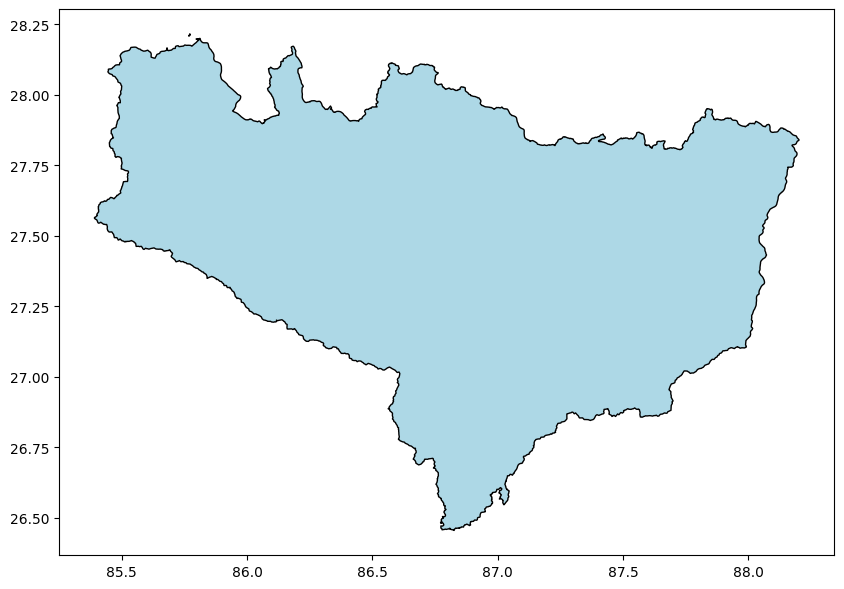

In [6]:
whole_koshi_basin.plot(edgecolor='black', facecolor='lightblue', figsize=(10, 10))
plt.show()

In [7]:
ee_physio_koshi = ee.FeatureCollection(geemap.geopandas_to_ee(whole_koshi_basin))
print(ee_physio_koshi.getInfo())

{'type': 'FeatureCollection', 'columns': {'AREA': 'Float', 'AREA_SQKM': 'Float', 'DESCRIPTIO': 'String', 'LUT': 'Integer', 'LUT1': 'Integer', 'LUT2': 'Integer', 'LUT3': 'Integer', 'LUT4': 'Integer', 'LUT5': 'Integer', 'OBJECTID': 'Integer', 'PERIMETER': 'Float', 'PHYSIOGRA1': 'Integer', 'Shape_Area': 'Float', 'Shape_Leng': 'Float', 'system:index': 'String'}, 'features': [{'type': 'Feature', 'geometry': {'type': 'MultiPolygon', 'coordinates': [[[[87.22809658998568, 26.80121069661641], [87.23084948581516, 26.80338571238076], [87.22897557206505, 26.806769448451348], [87.23086521945436, 26.809104407742268], [87.23208514441393, 26.810611819879625], [87.23203017245453, 26.81410373360046], [87.23614211476684, 26.819182474991294], [87.23413093029825, 26.824783940126792], [87.23868767009998, 26.832053690825205], [87.23973105364524, 26.83476962271999], [87.2518519498077, 26.83621741430227], [87.25355986579524, 26.839259191258748], [87.26000492738552, 26.840616189985212], [87.2664846848204, 26.84

In [8]:
ee_basin = ee_physio_koshi

In [9]:
# Landsat collections
l4 = ee.ImageCollection("LANDSAT/LT04/C02/T1_L2")
l5 = ee.ImageCollection("LANDSAT/LT05/C02/T1_L2")
l7 = ee.ImageCollection("LANDSAT/LE07/C02/T1_L2")
l8 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
l9 = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2")


In [10]:
def cloudMaskTm(image):
    qa = image.select('QA_PIXEL')
    dilated = 1 << 1
    cloud = 1 << 3
    shadow = 1 << 4
    mask = qa.bitwiseAnd(dilated).eq(0) \
        .And(qa.bitwiseAnd(cloud).eq(0)) \
        .And(qa.bitwiseAnd(shadow).eq(0))
    return image.select(['SR_B1','SR_B2','SR_B3','SR_B4','SR_B5','SR_B7'],
                        ['B2','B3','B4','B5','B6','B7']).updateMask(mask)

def cloudMaskOli(image):
    qa = image.select('QA_PIXEL')
    dilated = 1 << 1
    cirrus = 1 << 2
    cloud = 1 << 3
    shadow = 1 << 4
    mask = qa.bitwiseAnd(dilated).eq(0) \
        .And(qa.bitwiseAnd(cirrus).eq(0)) \
        .And(qa.bitwiseAnd(cloud).eq(0)) \
        .And(qa.bitwiseAnd(shadow).eq(0))
    return image.select(['SR_B2','SR_B3','SR_B4','SR_B5','SR_B6','SR_B7'],
                        ['B2','B3','B4','B5','B6','B7']).updateMask(mask)


In [11]:
def filterCol(col, roi, date):
    return col.filterDate(date[0], date[1]).filterBounds(roi)

def landsat457(roi, date):
    col = filterCol(l4, roi, date) \
        .merge(filterCol(l5, roi, date)) \
        .merge(filterCol(l7, roi, date))
    return col.map(cloudMaskTm).median().clip(roi)

def landsat89(roi, date):
    col = filterCol(l8, roi, date).merge(filterCol(l9, roi, date))
    return col.map(cloudMaskOli).median().clip(roi)


In [12]:
years = [1990, 1995, 2000, 2005, 2010, 2015, 2020]

river_images = []

for year in years:
    if year < 2014:
        start = ee.Date.fromYMD(year - 1, 1, 1)
        end = ee.Date.fromYMD(year + 1, 12, 31)
        img = landsat457(ee_physio_koshi, [start, end])
    else:
        start = ee.Date.fromYMD(year, 1, 1)
        end = ee.Date.fromYMD(year, 12, 31)
        img = landsat89(ee_physio_koshi, [start, end])

    img = img.multiply(0.0000275).add(-0.2)

    bandMap = {
        'NIR': img.select('B5'),
        'SWIR': img.select('B6'),
        'RED': img.select('B4'),
        'GREEN': img.select('B3'),
        'BLUE': img.select('B2')
    }

    ndbi = img.expression('(SWIR - NIR) / (SWIR + NIR)', bandMap).rename('NDBI')
    mndwi = img.expression('(GREEN - SWIR) / (GREEN + SWIR)', bandMap).rename('MNDWI')

    river = ee.Image(0).where(mndwi.gt(0.2).And(ndbi.lt(-0.4)), year) \
        .selfMask().clip(ee_physio_koshi)

    river_images.append(river.toUint16().rename('river').set({
        'year': year,
        'system:time_start': start
    }))

riverCol = ee.ImageCollection(river_images)
riverChange = riverCol.select('river').min()


In [13]:
Map = geemap.Map(center=[27.5, 87], zoom=7)
Map.addLayer(ee_physio_koshi, {}, "Koshi Basin")
Map.addLayer(riverChange, {'min': 1990, 'max': 2020,
                           'palette': ['800080','0000FF','00FFFF','008000','FFFF00','FFA500','FF0000']},
             'River change')
Map


Map(center=[27.5, 87], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright', tr…